In [1]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot,
    aes,
    geom_point,
    geom_path,
    scale_x_continuous,
    scale_y_continuous,
    guides,
    theme,
    element_line,
    element_rect
)
from mizani.transforms import trans

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Guitar Neck ###
*Using a transformed x-axis to visualise guitar chords*

The x-axis is transformed to resemble the narrowing width of frets on a 25.5 inch Strat. To do that
we create custom transformation.

The key parts of *any* transform object are the `transform` and `inverse` functions.

In [2]:
class frets_trans(trans):
    """
    Frets Transformation
    """
    number_of_frets = 23               # Including fret 0
    domain = (0, number_of_frets-1)
    
    @staticmethod
    def transform(x):
        x = np.asarray(x)
        return 25.5 - (25.5 / (2 ** (x/12)))
    
    @staticmethod
    def inverse(x):
        x = np.asarray(x)
        return 12 * np.log2(25.5/(25.5-x))
    
    @classmethod
    def breaks_(cls, limits):
        # Fixed major breaks
        return cls.domain
    
    @classmethod
    def minor_breaks(cls, major, limits):
        # The major breaks as passed to this method are in transformed space.
        # The minor breaks are calculated in data space to reveal the 
        # non-linearity of the scale.
        _major = cls.inverse(major)
        minor = cls.transform(np.linspace(*_major, cls.number_of_frets))
        return minor

The above transform is different from most in that, breaks and minor breaks do not change. This is common of very specialized scales. It can also be a key requirement when creating graphics for demontration purposes. 

Some chord Data

In [3]:
# Notes: the 0 fret is an open strum, all other frets are played half-way between fret bars.
# The strings are 1:low E, 2: A, 3: D, 4: G, 5: B, 6: E
c_chord = pd.DataFrame({
    'Fret':   [0, 2.5, 1.5, 0, 0.5, 0],
    'String': [1, 2, 3, 4, 5, 6]
})

# Sequence based on the number of notes in the chord
c_chord['Sequence'] = list(range(1, 1+len(c_chord['Fret'])))

# Standard markings for a Stratocaster
markings = pd.DataFrame({
    'Fret':   [2.5, 4.5, 6.5, 8.5, 11.5, 11.5, 14.5, 16.5, 18.5, 20.5],
    'String': [3.5, 3.5, 3.5, 3.5, 2, 5, 3.5, 3.5, 3.5, 3.5]
})

Visualizing the chord

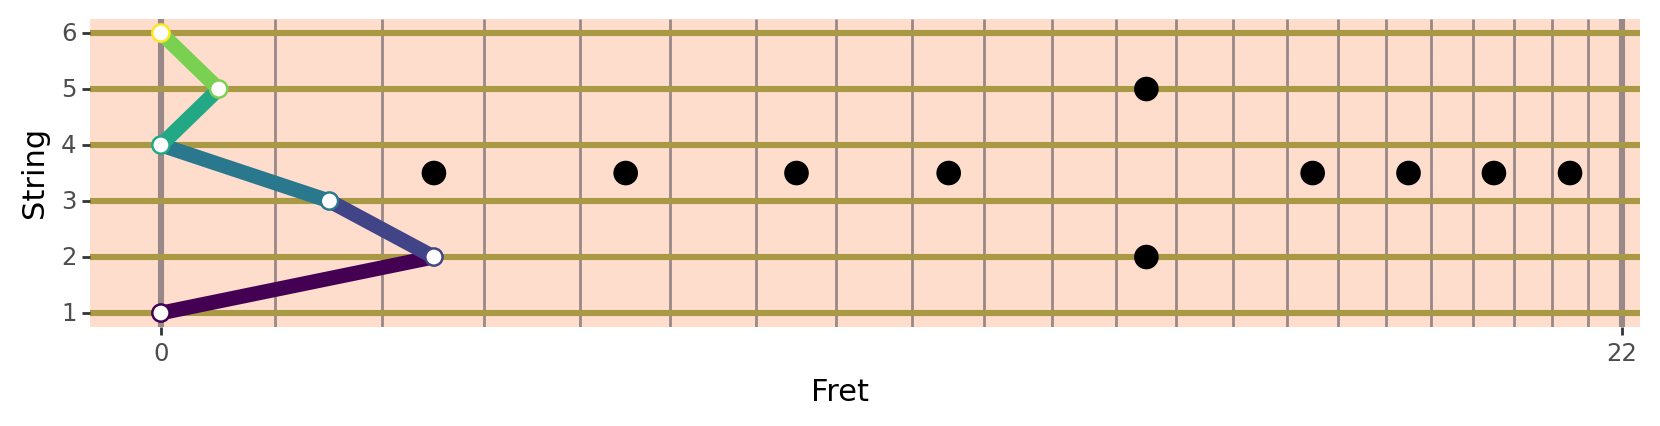

<ggplot: (326921078)>

In [4]:
# Look and feel of the graphic
neck_color = '#FFDDCC'
fret_color = '#998888'
string_color = '#AA9944'

neck_theme = theme(
    figure_size=(10, 2),
    panel_background=element_rect(fill=neck_color),
    panel_grid_major_y=element_line(color=string_color, size=2.2),
    panel_grid_major_x=element_line(color=fret_color, size=2.2),
    panel_grid_minor_x=element_line(color=fret_color, size=1)
)

# Gallery Plot

(ggplot(c_chord, aes('Fret', 'String'))
 + geom_path(aes(color='Sequence'), size=3)
 + geom_point(aes(color='Sequence'), fill='#FFFFFF', size=3)
 + geom_point(data=markings, fill='#000000', size=4)
 + scale_x_continuous(trans=frets_trans)
 + scale_y_continuous(breaks=range(0, 7), minor_breaks=[])
 + guides(color=False)
 + neck_theme
)

**Credit**: This example was motivated by [Jonathan Vitale](https://github.com/jonvitale) who wanted to create graphics for a guitar scale trainer.